In [8]:
import sys, os
sys.path.append(os.path.abspath("../src"))

from nets import MLP
from burger_ground_truth import burgers_ground_truth_fd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


# Burger's equation

Use the viscous form
\begin{align}
\dfrac{\partial u}{\partial t} + u \dfrac{\partial u}{\partial x} &= \nu \dfrac{\partial^2 u}{\partial x^2},\nonumber\\
u(0,x) &= -\sin(\pi x),\nonumber\\
u(t,x) &= 0 \,\,\,\,\,\,\hbox{at}\,\,\,\,\,\,x\in\{-1,1\},
\end{align}
where $u(t,x)$ represnet a velocity field. When $\nu > 0$, the solutions are smooth, balancing nonlinearity and diffusion. In the limit $\nu \rightarrow 0$, shock waves can form, making Burgers’ equation a prototypical model to study shock formation and related phenomena in fluid dynamics [1].

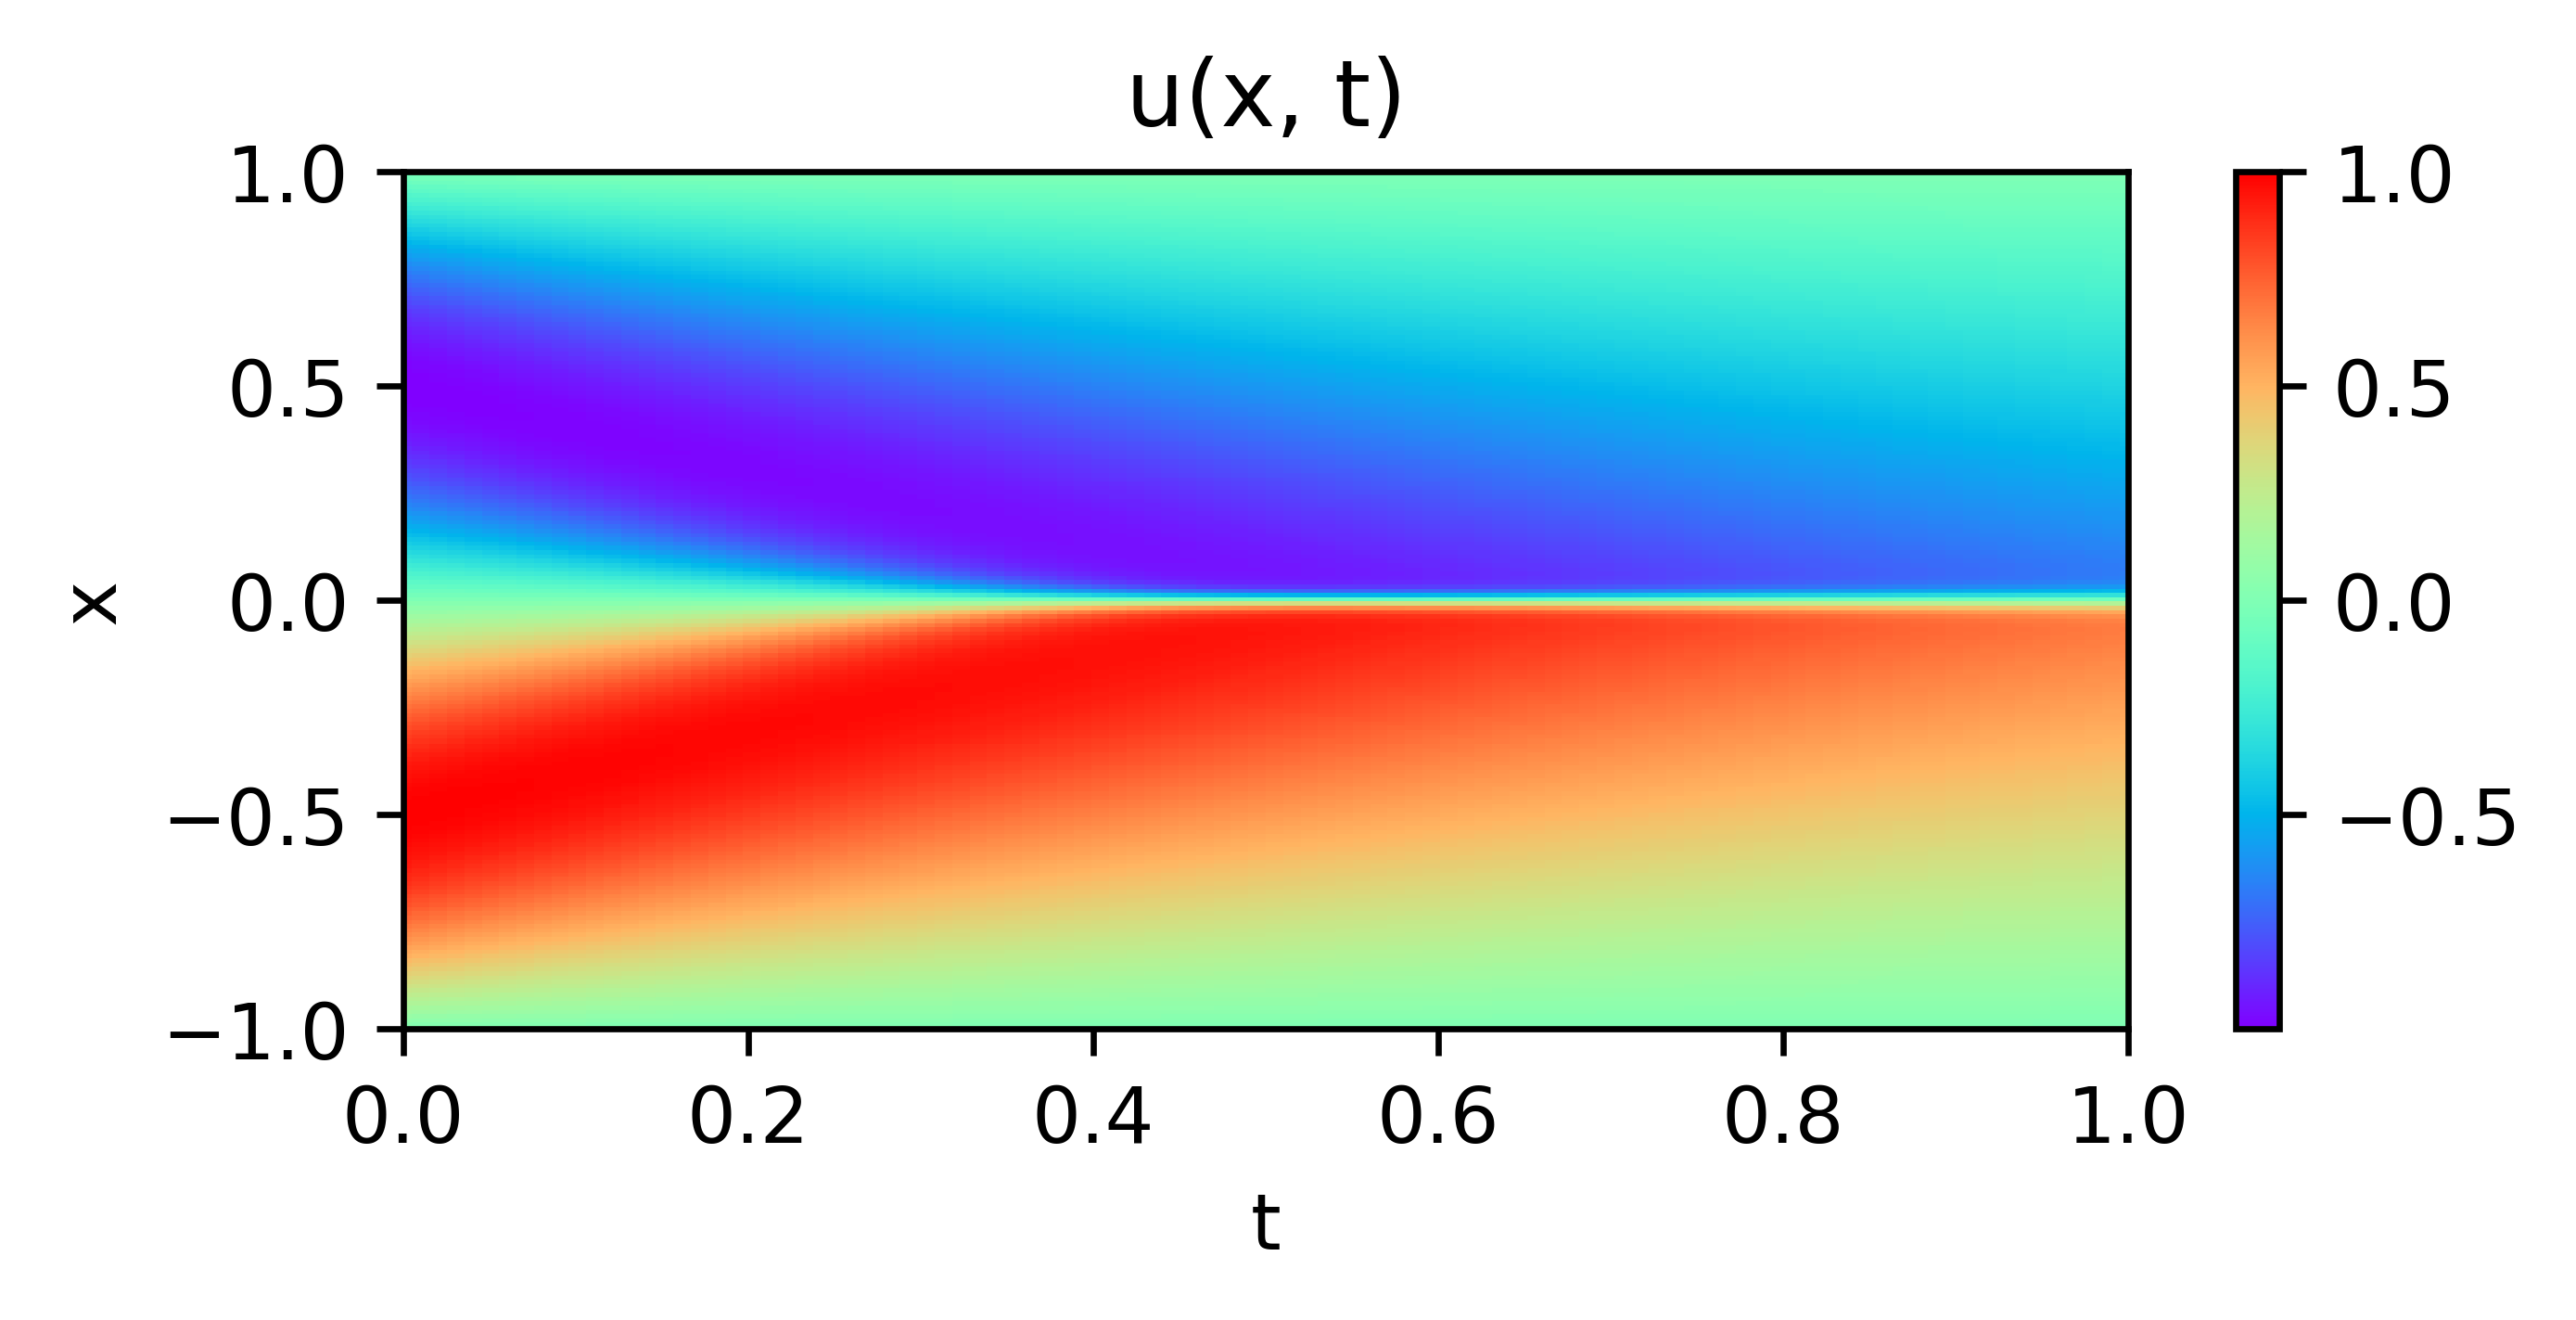

In [24]:
# Ground truth data using finite differences
x, t, U = burgers_ground_truth_fd()  # U: (Nt, Nx)

n, m = 100, 200

t_idx = np.linspace(0, len(t)-1, n).astype(int)
x_idx = np.linspace(0, len(x)-1, m).astype(int)

T = t[t_idx]            # (n,)
X = x[x_idx]            # (m,)
S = U[t_idx][:, x_idx]  # (n, m)

X0, T0 = np.meshgrid(X, T)  # (n, m)
plt.figure(figsize=(5, 2), dpi=600)
plt.pcolormesh(T0, X0, S, shading="auto", cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., 1.0)
plt.ylim(-1, 1)
plt.title("u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.show()

In [32]:
# indice t = 0.4
np.argmin(np.abs(t-0.6))


np.int64(3599)

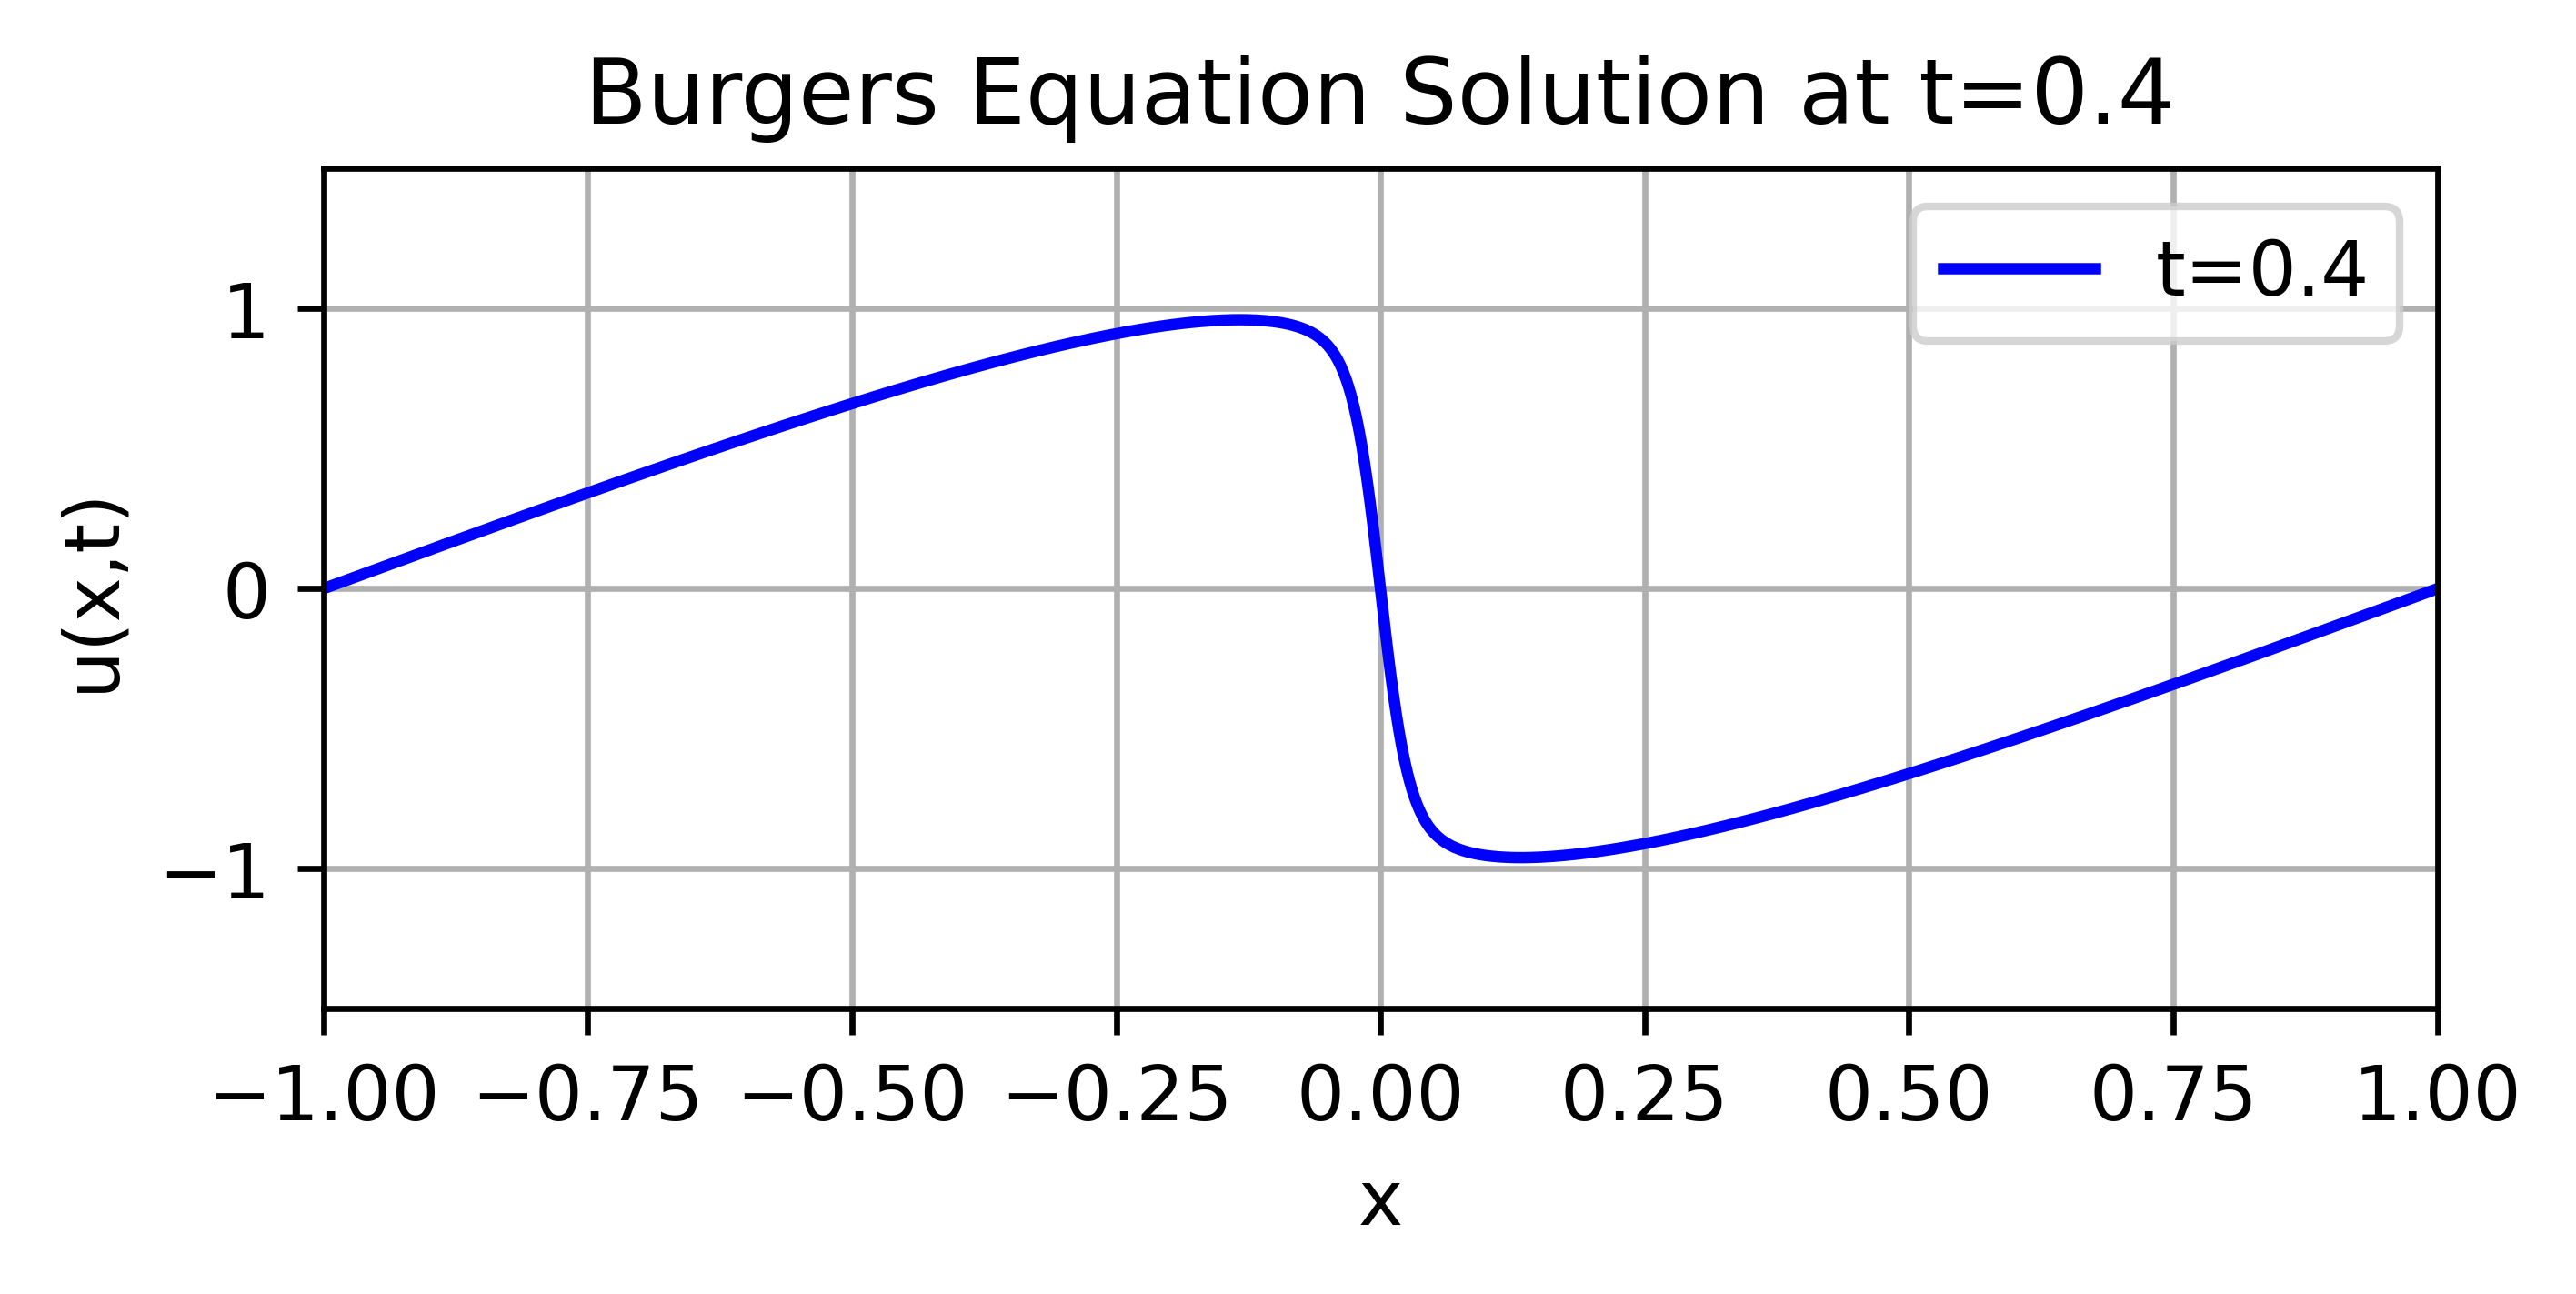

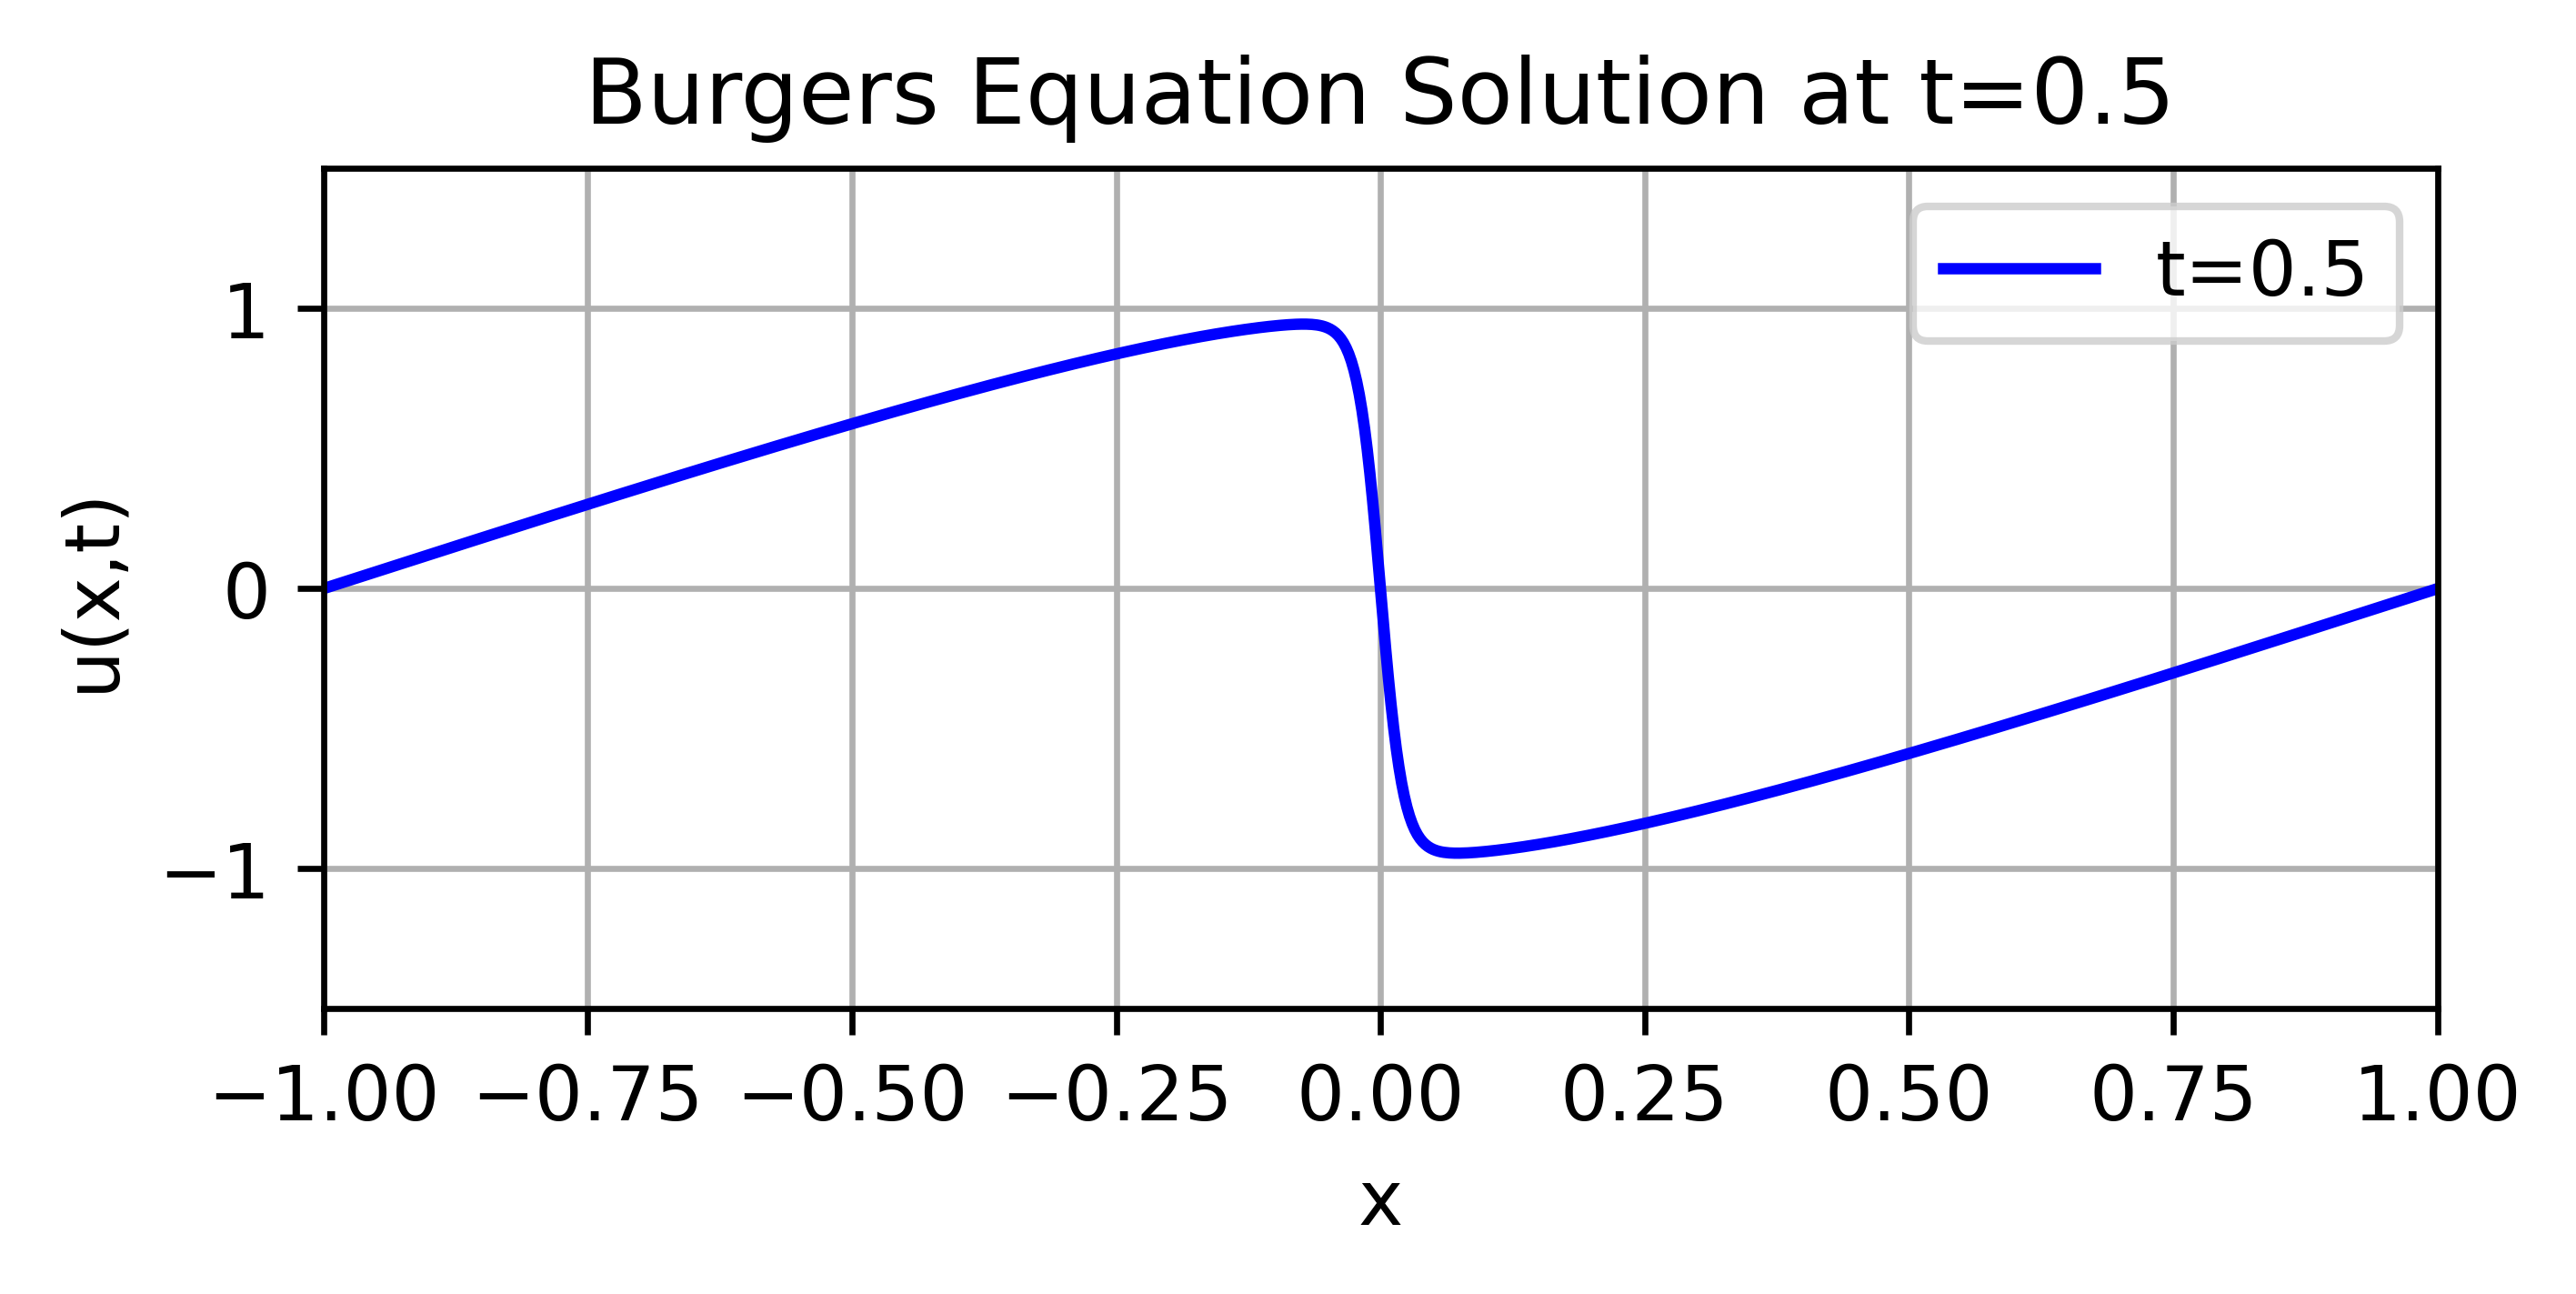

In [35]:
# 14 point en t=0.4 and t=0.6
t_points = [0.4, 0.5]
for tp in t_points:
    t_index = np.argmin(np.abs(t - tp))
    x_sample = x
    u_sample = U[t_index, :]

    plt.figure(figsize=(5, 2), dpi=600)
    plt.plot(x_sample, u_sample, 'b-', label=f't={tp}')
    plt.xlim(-1, 1)
    plt.ylim(-1.5, 1.5)
    plt.title(f'Burgers Equation Solution at t={tp}')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.grid()
    plt.legend()
    plt.show()


# PINNverse

In [17]:
net = MLP(2, 1, 3, 20, activation_fn = nn.Tanh())

In [18]:
net(torch.tensor(np.random.rand(10, 2), dtype=torch.float32))

tensor([[-0.0747],
        [-0.0852],
        [-0.0795],
        [-0.0714],
        [-0.0368],
        [-0.0627],
        [-0.0586],
        [-0.0768],
        [-0.0838],
        [-0.0450]], grad_fn=<AddmmBackward0>)

In [19]:
def burgers_residual(model, x, t, nu):
    u = model(torch.cat([x, t], dim=1))  
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    r = u_t + u*u_x - nu*u_xx
    return r, u

In [20]:
x_t = torch.tensor(np.random.rand(10, 1), dtype=torch.float32).requires_grad_(True)
t_t = torch.tensor(np.random.rand(10, 1), dtype=torch.float32).requires_grad_(True)

burgers_residual(net, x_t, t_t, nu=0.01)

(tensor([[-0.0054],
         [-0.0071],
         [-0.0060],
         [-0.0064],
         [-0.0077],
         [-0.0063],
         [-0.0073],
         [-0.0062],
         [-0.0054],
         [-0.0054]], grad_fn=<SubBackward0>),
 tensor([[-0.0600],
         [-0.0422],
         [-0.0628],
         [-0.0687],
         [-0.0406],
         [-0.0799],
         [-0.0416],
         [-0.0595],
         [-0.0734],
         [-0.0457]], grad_fn=<AddmmBackward0>))